
# Bank Customer Churn Prediction - Summary

## Dependencies

In [1]:
import os

import pandas as pd
import numpy as np

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report

# Function for creating model pipelines - sklearn
from sklearn.pipeline import make_pipeline

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
from imblearn.over_sampling import SMOTE

In [2]:
import pandas as pd
import numpy as np
import os

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
### sns.set_style('darkgrid')

# store elements as dictionary keys and their counts as dictionary values
from collections import Counter

# # scikit-learn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Function for creating model pipelines - imblearn
from imblearn.pipeline import make_pipeline as imbl_pipe

# # Over-sampling using SMOTE
# from imblearn.over_sampling import SMOTE

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn import tree

import xgboost as xgb
import tensorflow
from tensorflow.keras.models import load_model
import joblib



In [3]:
print(tensorflow.__version__)

2.15.0


In [4]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential

In [5]:

# # Keras
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.layers import Dense, Input, Dropout
# from tensorflow.keras.models import Sequential

In [6]:
# If you are runnig "Dark Reader" on Chrome,install "jupyterthemes 
#  and run these lines so the legends and axes become visible
## from jupyterthemes import jtplot
## jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# To reset default matplotlib rcParams
## jtplot.reset()


## Load Analytical Base Table

In [7]:
abt = pd.read_csv("SMOTE_DATA.csv")
print(f"Dataframe dimensions: {abt .shape}")
abt .head()

Dataframe dimensions: (15926, 11)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,1,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,1,0,43,2,125510.82,1,1,1,79084.10,0


In [8]:
abt .Exited.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

### Convert Geography And Gender

In [9]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder


# # Initialize the LabelEncoders
# label_encoder_geography = LabelEncoder()
# label_encoder_gender = LabelEncoder()

# # Encode the 'Geography' and 'Gender' columns
# df['Geography'] = label_encoder_geography.fit_transform(df['Geography'])
# df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])

### Separate dataframe into separate object

In [10]:
#Separate dataframe into separate object

# Object for target variable
y = abt.Exited

# object for input features
X = abt.drop(['Exited'], axis=1)

# display shapes of X and y
print(X.shape, y.shape)

(15926, 10) (15926,)


## Create a Train Test Split

In [11]:
# List numerical features
num_columns = X.select_dtypes(include='number').columns.tolist()
num_columns

['CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [12]:
# List categorical features
cat_columns = X.select_dtypes(include='object').columns.tolist()
cat_columns

[]

In [13]:
def class_count(a):
    counter=Counter(a)
    kv=[list(counter.keys()),list(counter.values())]
    abt2 = pd.DataFrame(np.array(kv).T, columns=['Exited','Count'])
    abt2['Count'] = abt2['Count'].astype('int64')
    abt2['%'] = round(abt2['Count'] / a.shape[0] * 100, 2)
    return abt2.sort_values('Count',ascending=False)

In [14]:
class_count(y)

,Exited,Count,%
0,1,7963,50.0
1,0,7963,50.0


In [15]:
random_state = 10

# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=random_state,
                                                    stratify=abt.Exited)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

11148 4778 11148 4778


In [16]:

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11148 entries, 14044 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      11148 non-null  int64  
 1   Geography        11148 non-null  int64  
 2   Gender           11148 non-null  int64  
 3   Age              11148 non-null  int64  
 4   Tenure           11148 non-null  int64  
 5   Balance          11148 non-null  float64
 6   NumOfProducts    11148 non-null  int64  
 7   HasCrCard        11148 non-null  int64  
 8   IsActiveMember   11148 non-null  int64  
 9   EstimatedSalary  11148 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 958.0 KB


In [17]:
num_features = [] 

for i in num_columns:
    location = X.columns.get_loc(i)
    num_features.append(location)
print(num_features)  

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [18]:

cat_features = []

for i in cat_columns:
    location = X.columns.get_loc(i)
    cat_features.append(location)
print(cat_features) 

[]


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Load your dataset and perform necessary preprocessing

# Initialize binary classification models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'LGBMClassifier': LGBMClassifier(device="gpu"),
    'XGBClassifier': XGBClassifier(tree_method="gpu_hist")
}

# Initialize parameters for grid search for binary classification
param_grids = {
    'LogisticRegression': {'C': [0.1, 1], 'solver': ['lbfgs']},
    'RandomForestClassifier': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'AdaBoostClassifier': {'n_estimators': [50, 200], 'learning_rate': [0.01, 1]},
    'ExtraTreesClassifier': {'n_estimators': [50, 200], 'max_depth': [None, 10]},
    'LGBMClassifier': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.2]},
    'XGBClassifier': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.2]}
}

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize DataFrame for binary classification metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_SCORE'])

# Loop through each binary classification model
for model_name, model in models.items():
    # Grid search for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=kf, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_
    # Save the best model using joblib
    joblib.dump(best_model, f'./ML_MODELS/{model_name}_SMOTE_best_model.joblib')
    # Predictions on test set
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    # Calculate binary classification metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba[:, 1])  # Use probability for class 1

    print('#############################################')
    print('Model Name: ', model_name)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1_Score:', f1)
    print('AUC_SCORE', auc_score)
    print('#############################################')

    # Append metrics to the DataFrame
    metrics_df = metrics_df._append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1_Score': f1, 'AUC_SCORE': auc_score}, ignore_index=True)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# Display binary classification metrics DataFrame
print(metrics_df)


#############################################
Model Name:  LogisticRegression
Accuracy:  0.6584344914190038
Precision:  0.6555692560624743
Recall:  0.6676433654248639
F1_Score: 0.6615512235586893
AUC_SCORE 0.7099947593625802
#############################################
[[1551  838]
 [ 794 1595]]
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      2389
           1       0.66      0.67      0.66      2389

    accuracy                           0.66      4778
   macro avg       0.66      0.66      0.66      4778
weighted avg       0.66      0.66      0.66      4778



C:\Users\mkahs\AppData\Local\Temp\ipykernel_38548\4275737618.py:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = metrics_df._append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1_Score': f1, 'AUC_SCORE': auc_score}, ignore_index=True)


#############################################
Model Name:  RandomForestClassifier
Accuracy:  0.8476349937212223
Precision:  0.8493899873790492
Recall:  0.845123482628715
F1_Score: 0.8472513638271087
AUC_SCORE 0.9225579742229322
#############################################
[[2031  358]
 [ 370 2019]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2389
           1       0.85      0.85      0.85      2389

    accuracy                           0.85      4778
   macro avg       0.85      0.85      0.85      4778
weighted avg       0.85      0.85      0.85      4778

#############################################
Model Name:  AdaBoostClassifier
Accuracy:  0.8135203013813311
Precision:  0.8120833333333334
Recall:  0.8158225198827962
F1_Score: 0.8139486322823137
AUC_SCORE 0.8962329260961491
#############################################
[[1938  451]
 [ 440 1949]]
              precision    recall  f1-score   support

           0       

c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


#############################################
Model Name:  XGBClassifier
Accuracy:  0.8495186270406028
Precision:  0.8447563996696945
Recall:  0.856425282544998
F1_Score: 0.8505508210351279
AUC_SCORE 0.9267244649459878
#############################################
[[2013  376]
 [ 343 2046]]
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      2389
           1       0.84      0.86      0.85      2389

    accuracy                           0.85      4778
   macro avg       0.85      0.85      0.85      4778
weighted avg       0.85      0.85      0.85      4778

                    Model  Accuracy  Precision    Recall  F1_Score  AUC_SCORE
0      LogisticRegression  0.658434   0.655569  0.667643  0.661551   0.709995
1  RandomForestClassifier  0.847635   0.849390  0.845123  0.847251   0.922558
2      AdaBoostClassifier  0.813520   0.812083  0.815823  0.813949   0.896233
3    ExtraTreesClassifier  0.850565   0.849104  0.852658  0.850877   

c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [23:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


c:\Users\mkahs\Repository\Nishat_CHURN\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [23:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


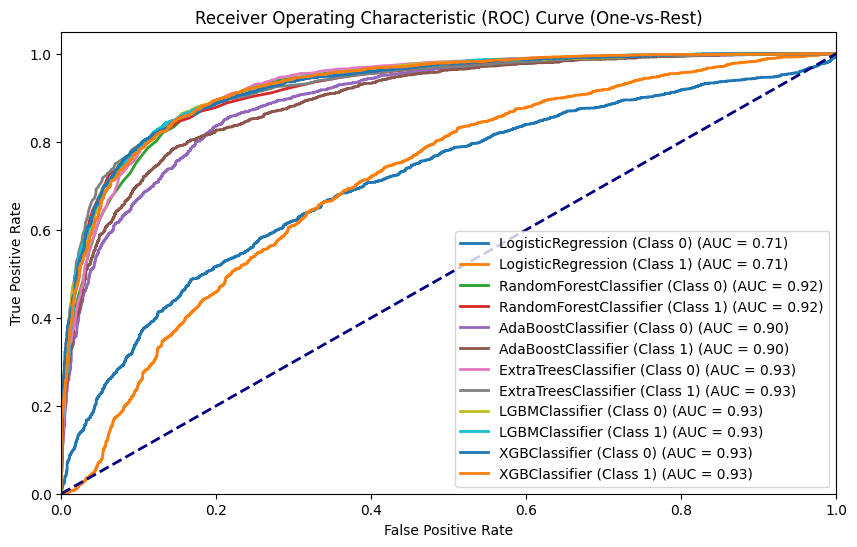

<Figure size 640x480 with 0 Axes>

In [21]:
plt.figure(figsize=(10, 6))

for model_name, model in models.items():
    best_model = joblib.load(f'./ML_MODELS/{model_name}_SMOTE_best_model.joblib')
    y_proba = best_model.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class (One-vs-Rest)
    n_classes = len(np.unique(y_test))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, y_proba[:, i])  # Check if class matches i
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{model_name} (Class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()
plt.savefig("./Figures/ROC_AUC_CURVE_SMOTE_SHALLOW_ML.png")




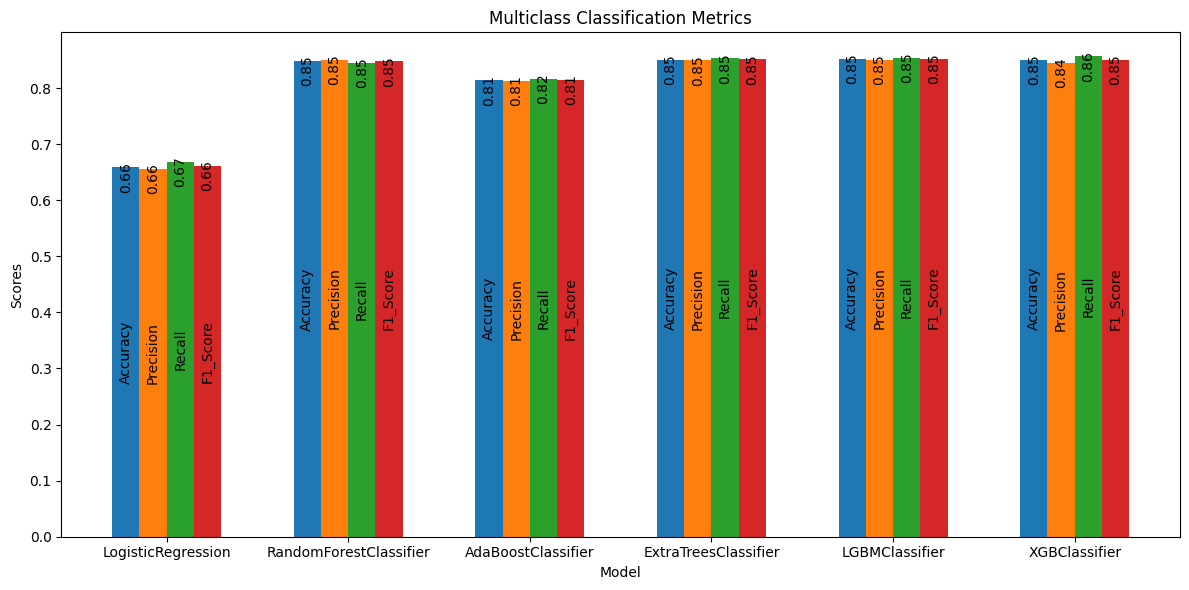

<Figure size 640x480 with 0 Axes>

In [22]:
plt.figure(figsize=(12, 6))
bar_width = 0.15
index = np.arange(len(models))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']

for i, metric in enumerate(metrics):
    plt.bar(index + i * bar_width, metrics_df[metric], bar_width, label=metric)

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Multiclass Classification Metrics')

# Adding metric names vertically in the middle of the bars
for i, metric in enumerate(metrics):
    for j, model_name in enumerate(models.keys()):
        plt.text(index[j] + i * bar_width, metrics_df[metric][j] / 2, metric, ha='center', va='center', rotation=90)

# Adding metric values inside the top end of the bars vertically
for i, metric in enumerate(metrics):
    for j, model_name in enumerate(models.keys()):
        value = metrics_df[metric][j]
        plt.text(index[j] + i * bar_width, value + 0.01, f'{value:.2f}', ha='center', va='top', rotation=90, fontsize=10)

plt.xticks(index + bar_width * 1.5, models.keys())

# Extend the border to avoid overlapping
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

# plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
plt.savefig("./Figures/KPI_CHART_SMOTE_SHALLOW_ML.png")